In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [12]:
truth = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/subsets/cosmos_truth_clean.fits'))
print(len(truth))

# # Remove objects with large sky residuals
# for band in ['g', 'r', 'i', 'z']:
#     truth[band+'_sky'] = (truth['apflux_blobresid_'+band][:, -1]-truth['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
# mask = (truth['g_sky']>-0.002) & (truth['g_sky']<0.002)
# print(np.sum(mask)/len(mask))
# mask &= (truth['r_sky']>-0.003) & (truth['r_sky']<0.003)
# print(np.sum(mask)/len(mask))
# mask &= (truth['z_sky']>-0.006) & (truth['z_sky']<0.006)
# print(np.sum(mask)/len(mask))
# truth = truth[mask]
# print(len(truth))

# # Only keep isolated sources
# mask = (truth['fracflux_g']>-0.01) & (truth['fracflux_g']<0.01)
# print(np.sum(mask)/len(mask))
# mask &= (truth['fracflux_r']>-0.01) & (truth['fracflux_r']<0.01)
# print(np.sum(mask)/len(mask))
# mask &= (truth['fracflux_z']>-0.01) & (truth['fracflux_z']<0.01)
# print(np.sum(mask)/len(mask))
# truth = truth[mask]
# print(len(truth))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    truth['gmag'] = 22.5 - 2.5*np.log10(truth['flux_g']) - 3.214 * truth['ebv']
    truth['rmag'] = 22.5 - 2.5*np.log10(truth['flux_r']) - 2.165 * truth['ebv']
    truth['zmag'] = 22.5 - 2.5*np.log10(truth['flux_z']) - 1.211 * truth['ebv']
    truth['w1mag'] = 22.5 - 2.5*np.log10(truth['flux_w1']) - 0.184 * truth['ebv']
    truth['w2mag'] = 22.5 - 2.5*np.log10(truth['flux_w2']) - 0.113 * truth['ebv']
    truth['gmagerr'] = 1/np.sqrt(truth['flux_ivar_g'])/(truth['flux_g'])
    truth['rmagerr'] = 1/np.sqrt(truth['flux_ivar_r'])/(truth['flux_r'])
    truth['zmagerr'] = 1/np.sqrt(truth['flux_ivar_z'])/(truth['flux_z'])
    truth['w1magerr'] = 1/np.sqrt(truth['flux_ivar_w1'])/(truth['flux_w1'])
    truth['w2magerr'] = 1/np.sqrt(truth['flux_ivar_w2'])/(truth['flux_w2'])
    truth['gfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_g']) - 3.214 * truth['ebv']
    truth['rfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_r']) - 2.165 * truth['ebv']
    truth['zfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_z']) - 1.211 * truth['ebv']

truth_all = truth.copy()

1149893


In [5]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

tmp = Table()
tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104


Final matched objects = 2406432


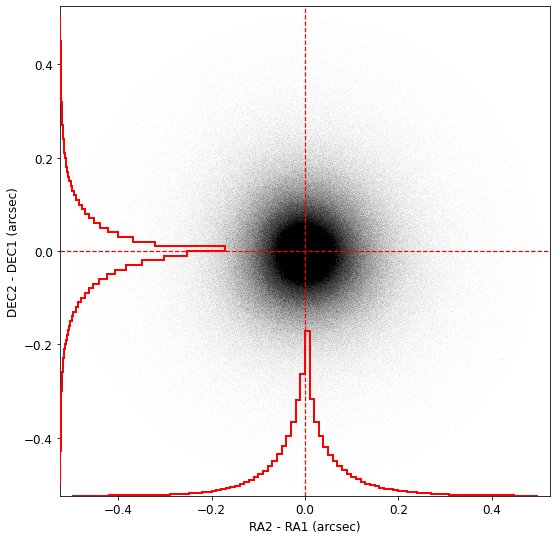

In [36]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], subs['ra'], subs['dec'], search_radius=0.5, plot_q=True, keep_all_pairs=True)

truth = truth[idx1]
subs = subs[idx2]

In [39]:
elglop, elgvlo = select_desi_targets.select_elgs(subs)

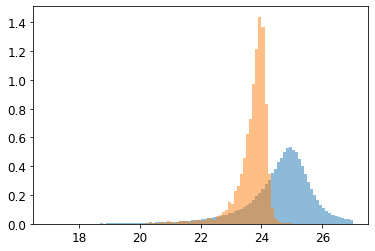

In [40]:
plt.hist(truth['gfibermag'][np.isfinite(truth['gfibermag'])], 100, range=(17, 27), alpha=0.5, density=True)
plt.hist(truth['gfibermag'][np.isfinite(truth['gfibermag']) & elglop], 100, range=(17, 27), alpha=0.5, density=True)
plt.show()

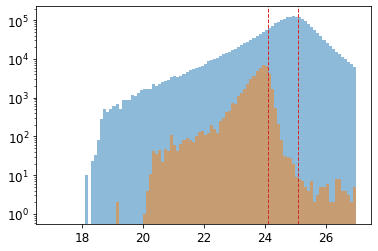

In [45]:
plt.hist(truth['gfibermag'][np.isfinite(truth['gfibermag'])], 100, range=(17, 27), alpha=0.5, log=True)
plt.hist(truth['gfibermag'][np.isfinite(truth['gfibermag']) & elglop], 100, range=(17, 27), alpha=0.5, log=True)
plt.axvline(24.1, lw=1, ls='--', color='C3')
plt.axvline(25.1, lw=1, ls='--', color='C3')
plt.show()

In [42]:
mask = elglop & (truth['gfibermag']>25.1)
np.sum(mask)/np.sum(elglop)

0.0022073250490516677

In [52]:
bitvalues = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
bitnames = ['NPRIMARY', 'BRIGHT', 'SATUR_G', 'SATUR_R', 'SATUR_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEM1', 'WISEM2', 'BAILOUT', 'MEDIUM', 'GALAXY', 'CLUSTER']

def bitmask_summary(mask_values, bitnames, bitvalues):
    mask_values = np.array(mask_values, dtype=np.uint64)
    tmp = Table()
    tmp['name'] = bitnames
    tmp['bit'] = bitvalues
    tmp['count'] = 0
    for index in range(len(bitvalues)):
        bit = bitvalues[index]
        tmp['count'][index] = np.sum(mask_values & (2**bit)>0)
    tmp['frac (%)'] = tmp['count']/len(mask_values)*100
    tmp['frac (%)'].format = '%.3f'
    return tmp

In [53]:
bitmask_summary(subs['maskbits'][elglop], bitnames, bitvalues)

name,bit,count,frac (%)
str9,int64,int64,float64
NPRIMARY,0,2,0.004
BRIGHT,1,0,0.000
SATUR_G,2,0,0.000
SATUR_R,3,0,0.000
SATUR_Z,4,0,0.000
ALLMASK_G,5,0,0.000
ALLMASK_R,6,0,0.000
ALLMASK_Z,7,0,0.000
WISEM1,8,62,0.127


In [54]:
bitmask_summary(subs['maskbits'], bitnames, bitvalues)

name,bit,count,frac (%)
str9,int64,int64,float64
NPRIMARY,0,192,0.008
BRIGHT,1,0,0.000
SATUR_G,2,0,0.000
SATUR_R,3,0,0.000
SATUR_Z,4,93,0.004
ALLMASK_G,5,0,0.000
ALLMASK_R,6,0,0.000
ALLMASK_Z,7,0,0.000
WISEM1,8,4830,0.201


In [58]:
bitmask_summary(truth['maskbits'][elglop], bitnames, bitvalues)

name,bit,count,frac (%)
str9,int64,int64,float64
NPRIMARY,0,0,0.000
BRIGHT,1,0,0.000
SATUR_G,2,1,0.002
SATUR_R,3,138,0.282
SATUR_Z,4,48,0.098
ALLMASK_G,5,0,0.000
ALLMASK_R,6,0,0.000
ALLMASK_Z,7,0,0.000
WISEM1,8,62,0.127


In [55]:
bitmask_summary(truth['maskbits'], bitnames, bitvalues)

name,bit,count,frac (%)
str9,int64,int64,float64
NPRIMARY,0,0,0.000
BRIGHT,1,0,0.000
SATUR_G,2,199,0.008
SATUR_R,3,5333,0.222
SATUR_Z,4,3378,0.140
ALLMASK_G,5,0,0.000
ALLMASK_R,6,0,0.000
ALLMASK_Z,7,0,0.000
WISEM1,8,4814,0.200


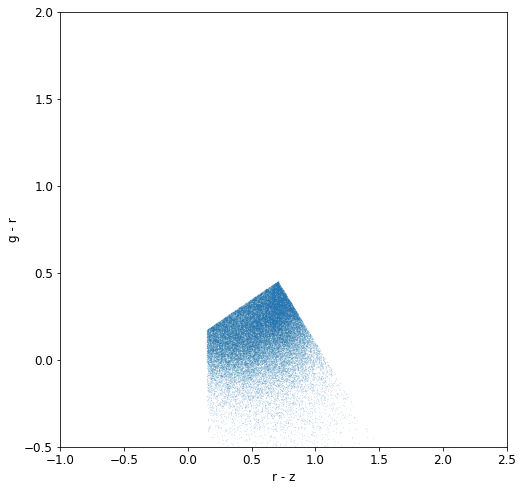

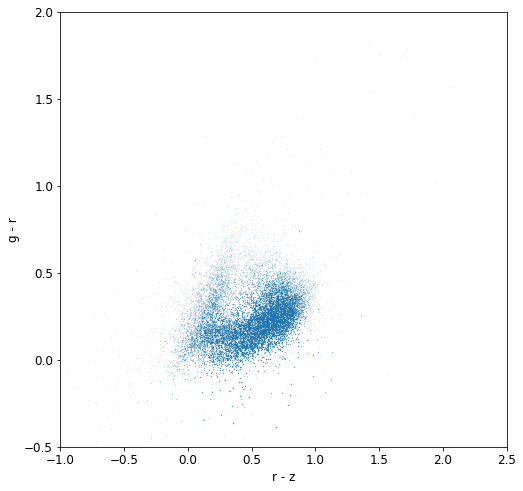

In [62]:
mask0 = elglop.copy()

plt.figure(figsize=(8, 8))
plt.plot((subs['rmag']-subs['zmag'])[mask0], (subs['gmag']-subs['rmag'])[mask0], '.', ms=0.1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

plt.figure(figsize=(8, 8))
plt.plot((truth['rmag']-truth['zmag'])[mask0], (truth['gmag']-truth['rmag'])[mask0], '.', ms=0.1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()

0.0028204708960104644


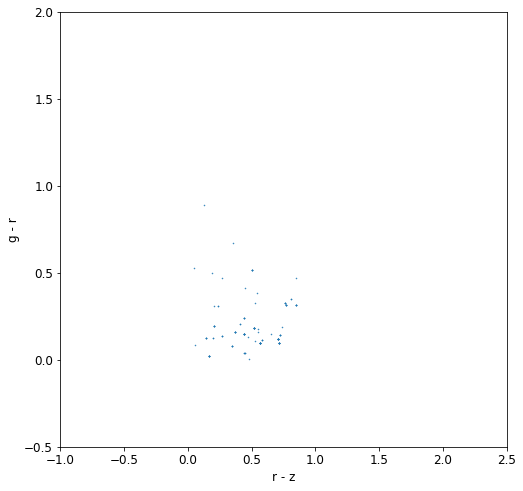

In [68]:
mask = (truth['maskbits']&2**2>0) | (truth['maskbits']&2**3>0) | (truth['maskbits']&2**4>0)
print(np.sum(mask & mask0)/np.sum(mask0))

plt.figure(figsize=(8, 8))
plt.plot((truth['rmag']-truth['zmag'])[mask0 & mask], (truth['gmag']-truth['rmag'])[mask0 & mask], '.', ms=1)
plt.xlabel('r - z')
plt.ylabel('g - r')
plt.axis([-1, 2.5, -0.5, 2])
plt.show()